In [1]:
import warnings
warnings.filterwarnings('ignore')
import os

In [2]:
__file__ = 'baseline-BCNN-InceptionResNetV2'
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [3]:
from keras.preprocessing.image import ImageDataGenerator
from glob import glob
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras
from keras.applications.inception_v3 import InceptionV3
from keras.applications.xception import Xception
from keras.applications.resnet50 import ResNet50
from keras_applications.resnext import ResNeXt50
from keras.applications.nasnet import NASNetLarge
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import *
import PIL
import time

def preprocess_img(x):
    x = x / 127.5
    x -= 1.
    return x

Using TensorFlow backend.


In [4]:
path_data = '../garbage_classify/train_data'
batch_size = 16
img_size = 299
img_width = img_size
img_height = img_size
random_seed = 201908
path_data_train = '../tmp/data_train/'
path_data_valid = '../tmp/data_valid/'
labels_file = '../tmp/labels_raw.csv'

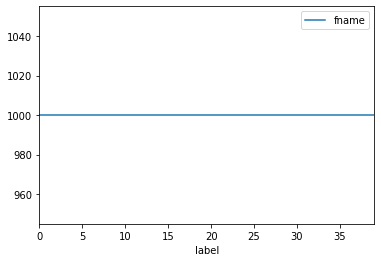

In [5]:
labels_train = pd.read_csv('../tmp/labels_train.csv')
labels_valid = pd.read_csv('../tmp/labels_valid.csv')
n_classess = labels_train.label.unique().shape[0]
labels_train.groupby(by='label').count().plot()

In [6]:
labels_train.label = labels_train.label.apply(lambda x: f'{x:02d}')
labels_valid.label = labels_valid.label.apply(lambda x: f'{x:02d}')
# labels_train['label_bin'].values = keras.utils.np_utils.to_categorical(
#     labels_train.label, n_classess)

In [7]:
ig = ImageDataGenerator(preprocessing_function=preprocess_img)

params_g = dict(
    batch_size=batch_size,
    # directory=path_data,
    # class_mode='other',
    x_col='fname',
    y_col='label',
    target_size=(img_width, img_height),
    interpolation='lanczos',
    seed=random_seed)

train_g = ig.flow_from_dataframe(
    labels_train, path_data_train, **params_g)
valid_g = ig.flow_from_dataframe(
    labels_valid, path_data_valid, **params_g)

Found 40000 validated image filenames belonging to 40 classes.
Found 2978 validated image filenames belonging to 40 classes.


In [8]:
from keras.initializers import *
from keras.regularizers import l2


def _outer_product(x):
    '''Calculate outer-products of two tensors.
    Args:
        x: a list of two tensors.
        Assume that each tensor has shape = (size_minibatch, total_pixels, size_filter)
    Returns:
        Outer-products of two tensors.
    '''
    return keras.backend.batch_dot(x[0], x[1], axes=[1, 1]) / x[0].get_shape().as_list()[1]

def _signed_sqrt(x):
    '''Calculate element-wise signed square-root.
    Args:
        x: input tensor.
    Returns:
        Element-wise signed square-root tensor.
    '''
    return keras.backend.sign(x) * keras.backend.sqrt(keras.backend.abs(x) + 1e-9)

def _l2_normalize(x, axis=-1):
    '''Calculate L2 normalization.
    Args:
        x: input tensor.
        axis: axis for narmalization.
    Returns:
        L2 normalized tensor.
    '''
    return keras.backend.l2_normalize(x, axis=axis)

In [9]:
def build_bcnn(pre_train_model,
               name_initializer='glorot_normal',
               no_last_layer_backbone=-1,
               no_class=40,
               decay_weight_rate=0.0,
               name_activation='softmax'):
    ######################
    # Combine two models #
    ######################

    # Extract features form detecotr
    model_detector = pre_train_model
    output_detector = model_detector.layers[no_last_layer_backbone].output
    shape_detector = model_detector.layers[no_last_layer_backbone].output_shape

    # Extract features from extractor
    model_extractor = pre_train_model
    output_extractor = model_extractor.layers[no_last_layer_backbone].output
    shape_extractor = model_extractor.layers[no_last_layer_backbone].output_shape

    # Reshape tensor to (minibatch_size, total_pixels, filter_size)
    output_detector = Reshape(
        [shape_detector[1]*shape_detector[2], shape_detector[-1]])(output_detector)
    output_extractor = Reshape(
        [shape_extractor[1]*shape_extractor[2], shape_extractor[-1]])(output_extractor)

    # Outer-products
    x = Lambda(_outer_product)([output_detector, output_extractor])
    # Reshape tensor to (minibatch_size, filter_size_detector*filter_size_extractor)
    x = Reshape([shape_detector[-1]*shape_extractor[-1]])(x)
    # Signed square-root
    x = Lambda(_signed_sqrt)(x)
    # L2 normalization
    x = Lambda(_l2_normalize)(x)


    ###############################
    # Attach full-connected layer #
    ###############################

    if name_initializer is not None:
        name_initializer = eval(name_initializer+'()')

    # FC layer
    x = Dense(
        units=no_class,
        kernel_initializer=name_initializer,
        kernel_regularizer=l2(decay_weight_rate))(x)
    output_tensor = Activation(name_activation)(x)


    #################
    # Compile model #
    #################

    model_bcnn = Model(inputs=pre_train_model.input, outputs=[output_tensor])
    return model_bcnn

In [10]:
base_model = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))

Instructions for updating:
Colocations handled automatically by placer.


In [11]:
# from keras.applications.vgg16 import VGG16
# input_tensor = Input(shape=[img_width, img_height, 3])
# m = VGG16(weights='imagenet', include_top=False,input_tensor=input_tensor)

In [12]:
# for i, layer in enumerate(base_model.layers):
#     print(i, layer.name)

In [13]:
model = build_bcnn(base_model)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 149, 149, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 149, 149, 32) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

batch_normalization_129 (BatchN (None, 17, 17, 192)  576         conv2d_129[0][0]                 
__________________________________________________________________________________________________
batch_normalization_132 (BatchN (None, 17, 17, 192)  576         conv2d_132[0][0]                 
__________________________________________________________________________________________________
activation_129 (Activation)     (None, 17, 17, 192)  0           batch_normalization_129[0][0]    
__________________________________________________________________________________________________
activation_132 (Activation)     (None, 17, 17, 192)  0           batch_normalization_132[0][0]    
__________________________________________________________________________________________________
block17_14_mixed (Concatenate)  (None, 17, 17, 384)  0           activation_129[0][0]             
                                                                 activation_132[0][0]             
__________

In [14]:
# base_model = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))

# x = base_model.output
# x = GlobalAveragePooling2D()(x)
# x = Dense(128, activation='relu')(x)
# x=Dropout(0.3)(x)

# predictions = Dense(n_classess, activation='softmax')(x)
# model = Model(inputs=base_model.input, outputs=predictions)
# model.summary()

In [15]:
with open(f'../tmp/model_{__file__}.json','w') as f:
    model_json = model.to_json()
    f.write(model_json)

In [16]:
ckpt = ModelCheckpoint('../tmp/ckpt-'+__file__+'-Epoch_{epoch:03d}-acc_{acc:.5f}-val_acc_{val_acc:.5f}.h5', save_best_only=True, monitor='val_acc')

estop = EarlyStopping(monitor='val_acc', min_delta=1e-7,verbose=1, patience=20)

In [ ]:
model.compile(optimizer=Adam(lr=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

model.fit_generator(
    train_g,
    # steps_per_epoch=100,
    steps_per_epoch=train_g.n // batch_size,
    epochs=100,
    callbacks=[ckpt, estop],
    validation_data=valid_g,
    # validation_steps=1,
    validation_steps=valid_g.n // batch_size
)

Instructions for updating:
Use tf.cast instead.
Epoch 1/100
 117/2500 [>.............................] - ETA: 35:47 - loss: 3.6537 - acc: 0.0775

In [ ]:
!ls